# Damage-plasticity model with generic time stepping
This notebook is a work in progress on an abstract and general implementation of time integration algorithm for general damage-plasticity modes. It serves for the development of a package that can be configured by specifying the ingredients of thermodynamically based model

 - Vector of state variables $\boldsymbol{\eta}$
 - Vector of thermodynamic streses $\boldsymbol{\sigma}$
 - Helmholtz free energy $\psi(\boldsymbol{\eta})$
 - Threshold on thermodynamical forces  $f(\boldsymbol{\sigma},\boldsymbol{\eta})$ / Yield condition
 - Flow potential $\varphi(\boldsymbol{\sigma},\boldsymbol{\eta})$

as symbolic equations using the sympy package. The time-stepping algorithm gets generated automatically within the thermodynamically framework. The derived  evolution equations and return-mapping to the yield surface is performed using Newton-Raphson scheme.  

In [1]:
import sympy as sp
sp.init_printing()
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

The derivation is adopted for the purpose of code generation both in Python and C utilizing the `codegen` package provided in `sympy`. The expressions that are part of the time stepping algorithm are transformed to an executable code directly at the place where they are derived. At the end of the notebook the C code can be exported to external files and applied in external tools. 

In [2]:
from sympy.utilities.codegen import codegen

## TODO
 - The current implementation uses the threshold function linearized along $\lambda$ to represent the consistency condition. As the next step include the fully linearized set of evolution equations and threshold functions. This might be important for SLIDE 3.x, 2D and 3D problems (von Mises, Drucker-Prager). In the current one-dimensional problem it probably has no effect - this feature will be included in SLIDE-core notebook which should be able to generate all the other problems by configuring the thermodynamic inputs symbolically.  
 - Lambdified functions are now generated with substituted material parameters. The material parameters should be included as call parameters as well.
 - flow direction is now matched with the gradient of the flow potential - that is multiplied by the signs $\Upsilon$. This is a short cut that confuses - introduce a new symbol for $\Upsilon \partial_\boldsymbol{\sigma} \varphi$ to give the Python and C code a more consistent name.
 - Better symbols - instead of $\boldsymbol{\sigma}$ and $\boldsymbol{\eta}$ maybe use
 $\boldsymbol{\mathcal{S}}$ and $\boldsymbol{\mathcal{E}}$. For more general problems, this would be a better separation of the generalized stresses / real stresses and generalized kinematic state variables and real strains
 - Clearer naming convention for expressions like `d_phi_Eta` improve to distinguish the derivative operator and the call parameters in the generated functions. 

## Material parameters

In [3]:
E_b = sp.Symbol('E_b', real=True, nonnegative=True)
gamma = sp.Symbol('gamma', real=True, nonnegative=True)
K = sp.Symbol('K', real=True)
S = sp.Symbol('S', real=True)
r = sp.Symbol('r', real=True)
c = sp.Symbol('c', real=True)
tau_bar = sp.Symbol(r'\bar{\tau}', real=True, nonnegative=True)

In [4]:
material_params = {
    E_b:1, gamma:0.2, K:0.1, S:0.005, r:0.001, c:1, tau_bar:1, 
}

In [5]:
material_params = {
    E_b:1, gamma: 0.6, K:1, S:0.6, r:0.001, c:1, tau_bar:1, 
}

## State variables

In [6]:
s = sp.Symbol('s', real=True)
omega = sp.Symbol('omega', real=True, nonnegative=True)
omega.is_nonnegative
s_pi = sp.Symbol(r's_pi', real=True)
alpha = sp.Symbol('alpha', real=True)
z = sp.Symbol('z', real=True)

In [7]:
Eta = sp.Matrix([s_pi, z, alpha, omega])
Eta.T

## Helmholtz free energy

The starting point in the thermodynamical representation of a process is a potential function of time dependent state variables. To describe the evolution of the state correctly describing the energy dissipation of the system the gradient of the potential function with respect to the state variables provides the generalized forces. The forces are constrained to characterize specific material properties, e.g. strength, hardening.

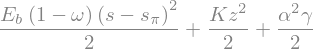

In [8]:
rho_psi = sp.Rational(1,2)* ( 
    (1-omega)*
    E_b*(s-s_pi)**2 + K * z**2 + gamma * alpha**2
)
rho_psi

## Thermodynamic forces

In [9]:
tau = sp.Symbol('tau', real=True)
tau_pi = sp.Symbol(r'tau_pi', real=True)
X = sp.Symbol('X', real=True)
Z = sp.Symbol('Z', real=True, nonnegative=True)
Y = sp.Symbol('Y', real=True)

In [10]:
Sigma = sp.Matrix([tau_pi, Z, X, Y])
Sigma.T

The introduce the thermodynamic forces we have to differentiate Hemholtz free energy
with respect to the kinematic state variables
\begin{align}
 \partial_\boldsymbol{\eta} (\rho \psi)
\end{align}

In [11]:
d_rho_psi_Eta = sp.Matrix([rho_psi.diff(eta) for eta in Eta])

To obtain consistent signs of the Helmholtz derivatives we define a sign switch operator so that all generalized forces are defined as positive for the respective conjugate state variable $\boldsymbol{\Upsilon}$. 

In [12]:
Sigma_signs = sp.diag(1,-1,-1,1)

The constitutive between generalized force and kinematic variables then read
\begin{align}
\boldsymbol{\sigma} = - \boldsymbol{\Upsilon} \, \partial_\boldsymbol{\eta} (\rho \psi) \
\end{align}

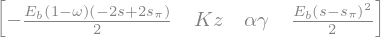

In [13]:
Sigma_Eta = -Sigma_signs * d_rho_psi_Eta
Sigma_Eta.T

**Executable code for** $\boldsymbol{\sigma}(s,\boldsymbol{\eta})$

In [14]:
get_Sigma_Eta = sp.lambdify(
    (s, Eta), Sigma_Eta.T.subs(material_params), 'numpy'
)

To derive the time stepping procedure we will need also the matrix of derivatives of the generalized stresses $\boldsymbol{\sigma}$ with respect to the kinematic variables $\boldsymbol{\eta}$ 
\begin{align}
 \partial_\boldsymbol{\eta} \boldsymbol{\sigma}
\end{align}

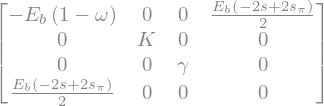

In [15]:
d_Sigma_Eta = sp.Matrix([ 
    Sigma_Eta.T.diff(eta_i) for eta_i in Eta 
] ).T
d_Sigma_Eta

**Executable Python code generation** $\partial_\boldsymbol{\eta} \boldsymbol{\sigma}(s,\boldsymbol{\eta})$

In [16]:
get_d_Sigma_Eta = sp.lambdify(
    (s, Eta), d_Sigma_Eta.subs(material_params),
)
get_d_Sigma_Eta_C = codegen(('d_Sigma_Eta', d_Sigma_Eta), 'C89', 'SLIDE1_3')

## Threshold function

To keep the framework general for different stress norms and hardening definitions let us first introduce a general function for effective stress. Note that the observable stress $\tau$ is identical with the plastic stress $\tau_\pi$ due to the performed sign switch in the definition of the thermodynamic forces.

In [17]:
tau_eff = sp.Function(r'\tau^{\mathrm{eff}}')(tau_pi, omega)
Q = sp.Function('Q')(tau_eff,X)
tau_eff

The stress norm is defined using the stress offset $X$, i.e. the kinematic hardening stress representing the shift of the origin of the yield locus.  

In [18]:
norm_Q = sp.sqrt(Q*Q)

General form of the yield condition then reads

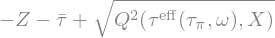

In [19]:
f = norm_Q - Z - tau_bar
f

Let us now introduce the back stress $X$ by defining the substitution for $Q = \tau^\mathrm{eff} - X$

In [20]:
subs_Q = {Q: tau_eff - X}
subs_Q

Further substitution rule introduces the effective stress as a function of damage as

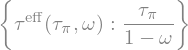

In [21]:
subs_tau_eff = {tau_eff: tau_pi / (1-omega)}
subs_tau_eff

After substitutions the yield function reads

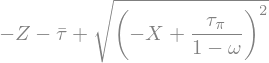

In [22]:
f_Sigma = f.subs(subs_Q).subs(subs_tau_eff)
f_Sigma

**Executable code generation** $f(\boldsymbol{\eta}, \boldsymbol{\sigma)}$

Note that this is a function of both the forces and kinematic state variables

In [23]:
get_f_Sigma = sp.lambdify(
    (Eta, Sigma), f_Sigma.subs(material_params), 'numpy'
)
get_f_Sigma_C = codegen(('f_Sigma', f_Sigma), 'C89', 'SLIDE1_3')

The derivative of $f$ required for time-stepping $\partial_\boldsymbol{\sigma} f$ is obtained as

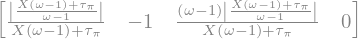

In [24]:
d_f_Sigma = f_Sigma.diff(Sigma)
sp.simplify(d_f_Sigma).T

**Executable code generation** $\partial_\boldsymbol{\sigma}f(\boldsymbol{\eta}, \boldsymbol{\sigma)}$

In [25]:
get_d_f_Sigma = sp.lambdify(
    (Eta, Sigma), d_f_Sigma, 'numpy'
)
get_d_f_Sigma_C = codegen(('d_f_Sigma', d_f_Sigma), 'C89', 'SLIDE1_3')

Due to the direct dependency of $f$ on $\boldsymbol{\eta}$ also the term $\partial_\boldsymbol{\eta} f$

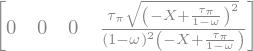

In [26]:
d_f_Eta = f_Sigma.diff(Eta)
d_f_Eta.T

**Executable Python code generation** $\partial_\boldsymbol{\eta}f(\boldsymbol{\eta}, \boldsymbol{\sigma)}$

In [27]:
get_d_f_Eta = sp.lambdify(
    (Eta, Sigma), d_f_Eta, 'numpy'
)
get_d_f_Eta_C = codegen(('d_f_Eta', d_f_Eta), 'C89', 'SLIDE1_3')

## Flow potential

For non-associative flow rule let us define an extension to be added to the threshold function 

In [28]:
phi_ext = S* (1-omega)**c / (r+1) * (Y/S)**(r+1)

The flow potential $\varphi(\boldsymbol{\eta}, \boldsymbol{\sigma})$ reads

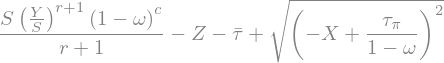

In [29]:
phi = f_Sigma + phi_ext
phi

and the corresponding directions of flow given as a product of the sign operator $\Upsilon$ and of the derivatives with respect to state variables 
$\boldsymbol{\Upsilon} \, \partial_{\boldsymbol{\sigma}} \varphi$

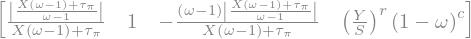

In [30]:
d_phi_Sigma = Sigma_signs * phi.diff(Sigma)
sp.simplify(d_phi_Sigma.T)

**Executable code generation** $\partial_\boldsymbol{\sigma}\varphi(\boldsymbol{\eta}, \boldsymbol{\sigma)}$

In [31]:
get_d_phi_Sigma = sp.lambdify(
    (Eta, Sigma), d_phi_Sigma.subs(material_params), 'numpy'
)
get_d_phi_Sigma_C = codegen(('d_phi_Sigma', d_phi_Sigma), 'C89', 'SLIDE1_3')

# Time integration scheme

## Summary of the backward Euler scheme
The derived expressions can be now plugged-in into a generic return mapping algorithm that efficiently identifies a state that satisfies the discrete consistency condition. The general structure of an implicit integration scheme reads

\begin{align}
\boldsymbol{\eta}_{n+1} &= \boldsymbol{\eta}_{n} + 
\lambda_\Delta \, \partial_{\boldsymbol{\sigma}} \varphi_{n+1} \\
f(\boldsymbol{\eta}_{n+1};  \lambda_\Delta) &= 0
\end{align}

To reach an admissible state let us linearize the threshold function at an interim state $j$ as
\begin{align}
f(\boldsymbol{\eta}_{n+1}; \lambda_\Delta )
& \approx
\left. f \right|_{\eta_{n+1},\lambda_\Delta} 
 + 
\left. \partial_\lambda f \right|_{\eta_{n+1},\lambda_\Delta}
\Delta \lambda
\end{align}

To define a generic return mapping we need to construct the  derivatives of the flow rule $f$ with respect to $\lambda$. The dependency of $f$ on $\lambda$ is intermediated via thermodynamic forces $\sigma$ and state variables $\boldsymbol{\eta}$
\begin{align}
f(\boldsymbol{\sigma}(\boldsymbol{\eta}(\lambda)), \boldsymbol{\eta}(\lambda)).
\end{align}
To correctly resolve the dependencies in the derivative $\partial_\lambda f_\boldsymbol{\sigma}$, we need to apply rules for composition and chaining of derivatives. Let us start with the composition rule rendering the derivative with respect to $\boldsymbol{\eta}$ in the form
\begin{align}
\partial_\boldsymbol{\eta} f(\boldsymbol{\sigma}(\boldsymbol{\eta}), \boldsymbol{\eta})
 &=
\partial_\boldsymbol{\sigma} f(\boldsymbol{\sigma}, \boldsymbol{\eta}) \, \partial_\boldsymbol{\eta}  \boldsymbol{\sigma}(\boldsymbol{\eta}) + \partial_\boldsymbol{\eta} f(\boldsymbol{\sigma}, \boldsymbol{\eta}).
\end{align}
By expanding the derivatives of $\boldsymbol{\eta}$ with respect to $\lambda_\Delta$ that will be abbreviate in index position as $\lambda$ for brevity we obtain
\begin{align}
\partial_\lambda f(\boldsymbol{\sigma}(\boldsymbol{\eta}(\lambda)), \boldsymbol{\eta}(\lambda))
 &=
\partial_\boldsymbol{\sigma} f(\boldsymbol{\sigma}, \boldsymbol{\eta}) \, \partial_\boldsymbol{\eta}  \boldsymbol{\sigma}(\boldsymbol{\eta}) \, \partial_\lambda \boldsymbol{\eta} + \partial_\boldsymbol{\eta} f(\boldsymbol{\sigma}, \boldsymbol{\eta}) \, \partial_\lambda \boldsymbol{\eta}
\end{align}
and after collecting terms
\begin{align}
\partial_\lambda f(\boldsymbol{\sigma}(\boldsymbol{\eta}(\lambda)), \boldsymbol{\eta}(\lambda))
 &=
[
\partial_\boldsymbol{\sigma} f(\boldsymbol{\sigma}, \boldsymbol{\eta}) \, \partial_\boldsymbol{\eta}  \boldsymbol{\sigma}(\boldsymbol{\eta})  + \partial_\boldsymbol{\eta} f(\boldsymbol{\sigma}, \boldsymbol{\eta})
] \,
\partial_\lambda  \boldsymbol{\eta}
\end{align}

The last term $\partial_\lambda \boldsymbol{\eta}$ can be obtained from the evolution equations
\begin{align}
\boldsymbol{\eta} = \dot{\lambda} \, \partial_\boldsymbol{\sigma} \varphi \; \implies
\partial_\lambda \boldsymbol{\eta} = 
\partial_\boldsymbol{\sigma} \varphi
\end{align}

Thus, by rewriting the linearized equation as a recurrence formula, the iteration algorithm is obtained
\begin{align}
&\left[
\left[
\partial_\boldsymbol{\sigma} f^{(k)}(\boldsymbol{\sigma}, \boldsymbol{\eta}) \,
\partial_\boldsymbol{\eta}  \boldsymbol{\sigma}^{(k)}(\boldsymbol{\eta})  +
\partial_\boldsymbol{\eta} f^{(k)}(\boldsymbol{\sigma}, \boldsymbol{\eta})
\right] \,
\partial_\boldsymbol{\sigma} \varphi^{(k)}(\boldsymbol{\sigma}, \boldsymbol{\eta})
\right]
\Delta \lambda
= - f^{(k)}\\
& \boldsymbol{\eta}^{(k+1)} = \boldsymbol{\eta}^{(k)} + 
 \lambda_\Delta \, \partial_{\boldsymbol{\sigma}} \varphi^{(k)} \\
&\lambda_{\Delta}^{(k+1)} = \lambda_{\Delta}^{(k)} + \Delta \lambda \\
&k = k + 1
\end{align}

## Implementation concept
The gradient operators needed for the time-stepping scheme have been derived above and are now available for the implementation of the numerical algorithm both in `Python` and `C89` languages

<table style="width:50%">
<tr>
<th>Symbol</th>
<th>Python</th>
<th>C89</th>
</tr>
<tr>
<td>$\partial_\boldsymbol{\sigma} f(\boldsymbol{\sigma}, \boldsymbol{\eta}) $  
</td>
<td>get_d_f_Sigma</td>
<td>get_d_f_Sigma_C</td>
</tr>
<tr>
<td>$\partial_\boldsymbol{\eta}  \boldsymbol{\sigma}(\boldsymbol{\eta}) $</td>
<td>get_d_Sigma_Eta</td>
<td>get_d_Sigma_Eta_C</td>
</tr>
<tr>
<td>$\partial_\boldsymbol{\eta} f(\boldsymbol{\sigma}, \boldsymbol{\eta}) $</td>
<td>get_d_f_Eta</td>
<td>get_d_f_Eta_C</td>
</tr>
<tr>
<td>$\partial_\boldsymbol{\sigma} \varphi(\boldsymbol{\sigma}, \boldsymbol{\eta}) $</td>
<td>get_d_f_Sigma</td>
<td>get_d_f_Sigma_C</td>
</tr>
<tr>
<td>$ f(\boldsymbol{\sigma}, \boldsymbol{\eta})$</td>
<td>get_f</td>
<td>get_f_C</td>
</tr>
</table>

To avoid repeated calculation of the same expressions, let us put the evaluation of $f$ and $\partial_\lambda f$ into a single procedure. The iteration loop can be constructed in such a way that the predictor for the next step can be calculated along with the residuum. In case that the residuum is below the required tolerance, the overhead for an extra calculated derivative is negligible or, with some care, can be even reused in the next time step.  

In [32]:
def get_f_df(s_n1, Eta_k):
    Sigma_k = get_Sigma_Eta(s_n1, Eta_k)[0]
    f_k = np.array([get_f_Sigma(Eta_k, Sigma_k)])
    d_f_Sigma_k = get_d_f_Sigma(Eta_k, Sigma_k)
    d_f_Eta_k = get_d_f_Eta(Eta_k, Sigma_k)
    d_phi_Sigma_k = get_d_phi_Sigma(Eta_k, Sigma_k)
    d_Sigma_Eta_k = get_d_Sigma_Eta(s_n1, Eta_k)
    d_f_Sigma_Eta_k = np.einsum(
        'ik,ji->jk', d_f_Sigma_k, d_Sigma_Eta_k) + d_f_Eta_k
    d_Eta_lambda_k = d_phi_Sigma_k
    d_f_lambda = np.einsum(
        'ki,kj->ij', d_f_Sigma_Eta_k, d_Eta_lambda_k)
    d_f_k = d_f_lambda
    return f_k, d_f_k, Sigma_k

The update of state variables for an updated $\lambda_\Delta$ is performed using this procedure. This can be still improved. However, as the following sheet will consider all the variables within a common vector of unknowns $\boldsymbol{\sigma}$ and $\lambda_\Delta$ let us keep the evolution update separate also in the algorithm below. 

In [33]:
def get_Eta_k1(s_n1, Eta_n, lam_k, Eta_k):
    Sigma_k = get_Sigma_Eta(s_n1, Eta_k)[0]
    d_phi_Sigma_k = get_d_phi_Sigma(Eta_k, Sigma_k)
    Eta_k1 = Eta_n + lam_k * d_phi_Sigma_k[:,0]
    return Eta_k1

The double loop over the time increments and over the return mapping iteration. The inner loop represents the material point level in a standard finite element calculation. The input is the maximum slip value, the number of time steps, the maximum number of iterations and a load function which can define cyclic loading as shown below. The procedure returns the record of $\boldsymbol{\eta}(t)$ and $\boldsymbol{\sigma}(t)$

In [34]:
def get_response(s_max=3, n_steps = 10, k_max=20, get_load_fn=lambda t: t):
    Eta_n = np.zeros((len(Eta),), dtype=np.float_)
    Eta_k = np.copy(Eta_n)
    Sigma_record = []
    Eta_record = []
    iter_record = []
    t_arr = np.linspace(0,1,n_steps+1)
    s_t = s_max * get_load_fn(t_arr) + 1e-9
    for s_n1 in s_t:
        lam_k = 0
        f_k, d_f_k, Sigma_k = get_f_df(s_n1, Eta_k)
        f_k_norm = np.linalg.norm(f_k)
        f_k_trial = f_k[-1]
        k = 0
        while k < k_max:
            if f_k_trial < 0 or f_k_norm < 1e-6:
                Eta_n[...] = Eta_k[...]
                Sigma_record.append(Sigma_k)
                Eta_record.append(np.copy(Eta_k))
                iter_record.append(k+1)
                break
            dlam = np.linalg.solve(d_f_k, -f_k)
            lam_k += dlam
            Eta_k = get_Eta_k1(s_n1, Eta_n, lam_k, Eta_k)
            f_k, d_f_k, Sigma_k = get_f_df(s_n1, Eta_k)
            f_k_norm = np.linalg.norm(f_k)
            k += 1
        else:
            print('no convergence')
    Sigma_arr = np.array(Sigma_record, dtype=np.float_)
    Eta_arr = np.array(Eta_record, dtype=np.float_)
    iter_arr = np.array(iter_record,dtype=np.int_)
    return t_arr, s_t, Eta_arr, Sigma_arr, iter_arr

# Support functions
To run some examples, let us define some infrastructure including a more complex loading history and postprocessing

## Loading history

This implementation uses the symbolic machinery which is not necessary a simpler data point based implementation with `numpy.interp1d` would be better ... later 

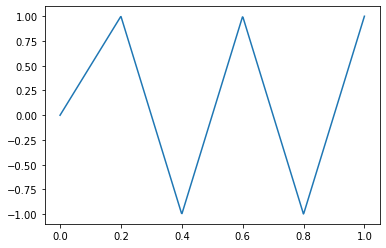

In [35]:
t, theta = sp.symbols(r't, \theta')
n_cycles = 5
A = 2
ups = np.array([((theta-2*cycle)*A+(1-A), theta-2*cycle<=1) 
                for cycle in range(n_cycles)])
downs = np.array([((1-(theta-(2*cycle+1)))*A+(1-A),(theta-(2*cycle+1))<=1) 
                  for cycle in range(n_cycles)])
ups[0,0] = theta
updowns = np.einsum('ijk->jik',np.array([ups, downs])).reshape(-1,2)
load_fn = sp.Piecewise(*updowns).subs(theta,t*n_cycles)
get_load_fn = sp.lambdify(t, load_fn,'numpy')
t_arr = np.linspace(0,1,600)
plt.plot(t_arr, get_load_fn(t_arr));

## Plotting functions
To simplify postprocessing examples, here are two aggregate plotting functions, one for the state and force variables, the other one for the evaluation of energies

In [36]:
def plot_Sigma_Eta(Sigma, Eta, ax1, ax2, ax3, ax4):
    colors = ['blue','red', 'green', 'black', 'magenta' ]
    n_step = len(Eta)
    s_pi_, z_, alpha_, omega_ = Eta_arr.T
    sig_pi_, Z_, X_, Y_ = Sigma_arr.T
    ax1.plot(s_t, sig_pi_, color='black', 
             label='n_steps = %g' % n_step)
    ax1.set_xlabel('$s$'); ax1.set_ylabel(r'$\tau$')
    ax1.legend()
    ax11 = ax1.twinx()
    ax11.plot(s_t, iter_arr, '-.')
    ax2.plot(t_arr, omega_, color='red', 
             label='n_steps = %g' % n_step)
    ax2.set_xlabel('$s$'); ax2.set_ylabel(r'$\omega$')
    ax22 = ax2.twinx()
    ax22.plot(t_arr, Y_, '-.', color='red', 
             label='n_steps = %g' % n_step)
    ax22.set_ylabel('$Y$')
    ax3.plot(t_arr, z_, color='green', 
             label='n_steps = %g' % n_step)
    ax3.set_xlabel('$s$'); ax3.set_ylabel(r'$z$')
    ax33 = ax3.twinx()
    ax33.plot(t_arr, Z_, '-.', color='green')
    ax33.set_ylabel(r'$Z$')
    ax4.plot(t_arr, alpha_, color='blue', 
             label='n_steps = %g' % n_step)
    ax4.set_xlabel('$s$'); ax4.set_ylabel(r'$Z$')
    ax44 = ax4.twinx()
    ax44.plot(t_arr, X_, '-.', color='blue')

In [37]:
from scipy.integrate import cumtrapz
def plot_work(ax, Eta_arr, Sigma_arr):
    W_arr = cumtrapz(Sigma_arr[:,0], s_t, initial=0)
    U_arr = Sigma_arr[:,0] * (s_t-Eta_arr[:,0]) / 2.0
    G_arr = W_arr - U_arr
    ax.plot(t_arr, W_arr, lw=2, color='black', label=r'$W$')
    ax.plot(t_arr, G_arr, color='black', label=r'$G$')
    ax.fill_between(t_arr, W_arr, G_arr, color='green', alpha=0.2)
    ax.set_xlabel('$s$'); ax3.set_ylabel(r'$E$')
    ax.legend()
    
sigma_signs = np.einsum('ii->i',np.array(Sigma_signs))
def plot_dissipation(ax, Eta_arr, Sigma_arr):    
    colors = ['blue','red', 'green', 'black', 'magenta' ]
    E_i = cumtrapz(Sigma_arr, Eta_arr, initial=0, axis=0)
    c = 'black'
    ax.plot(t_arr, E_i[:,0], '-.', lw=1, color=c)
    ax.fill_between(t_arr, E_i[:,0], 0, color=c, alpha=0.1)
    c = 'black'
    ax.plot(t_arr, E_i[:,0] + E_i[:,3], color=c, lw=1)
    ax.fill_between(t_arr, E_i[:,0] + E_i[:,3], E_i[:,0], 
                    color=c, alpha=0.2);
    c = 'blue'
    ax.plot(t_arr, E_i[:,1], '-.', lw=1, color='black')
    ax.fill_between(t_arr, E_i[:,1], 0, color=c, alpha=0.1)
    c = 'blue'
    ax.plot(t_arr, E_i[:,1] + E_i[:,2], color='black', lw=1)
    ax.fill_between(t_arr, E_i[:,1] + E_i[:,2], E_i[:,1], 
                    color=c, alpha=0.3);

# Examples

## Monotonic load 

Let's furst run the example with different size of the time step to see if there is any difference

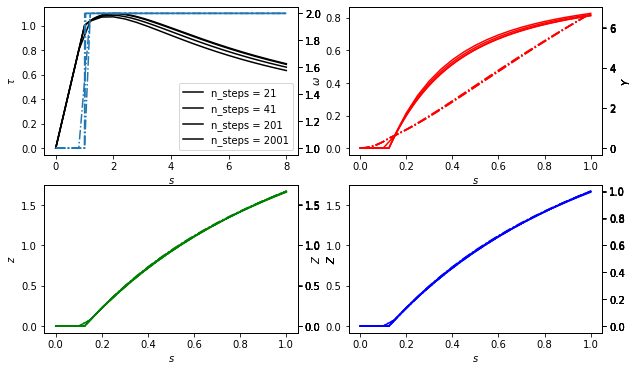

In [38]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,6))
for n_steps in [20, 40, 200, 2000]:
    t_arr, s_t, Eta_arr, Sigma_arr, iter_arr = get_response(
        s_max=8, n_steps=n_steps, k_max=10
    )
    plot_Sigma_Eta(Sigma_arr, Eta_arr, ax1, ax2, ax3, ax4)

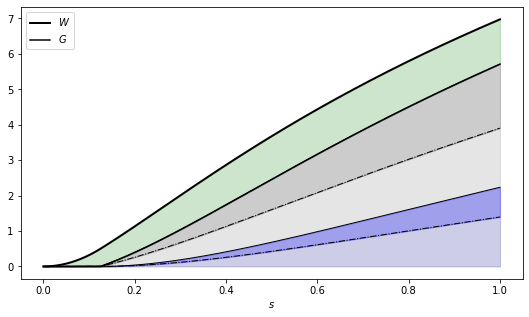

In [39]:
fig, ax = plt.subplots(1,1,figsize=(9, 5))
plot_work(ax, Eta_arr, Sigma_arr)
plot_dissipation(ax, Eta_arr, Sigma_arr)

## Cyclic loading

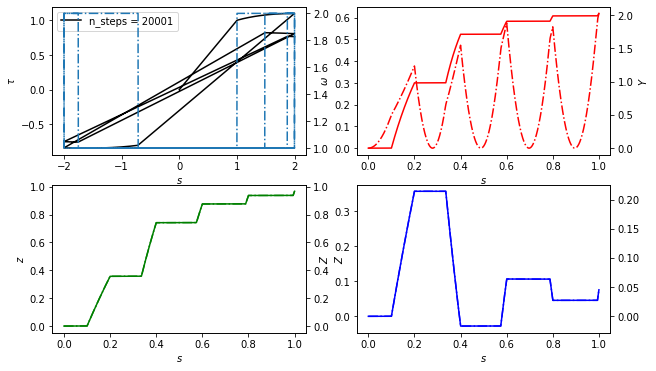

In [40]:
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(10,6))
t_arr, s_t, Eta_arr, Sigma_arr, iter_arr = get_response(
    s_max=2, n_steps=20000, k_max=20, get_load_fn=get_load_fn
)
plot_Sigma_Eta(Sigma_arr, Eta_arr, ax1, ax2, ax3, ax4)

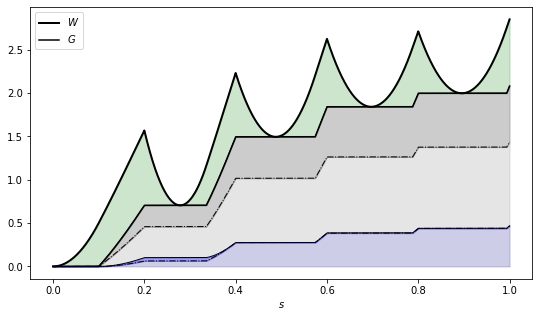

In [41]:
fig, ax = plt.subplots(1,1,figsize=(9, 5))
plot_work(ax, Eta_arr, Sigma_arr)
plot_dissipation(ax, Eta_arr, Sigma_arr)

# Code generation

See the docs for the code generation, the latexified  sympy symbols 
must be substituted such that they can act as standard C variable names

In [42]:
print(get_f_Sigma_C[0][1])

/******************************************************************************
 *                      Code generated with sympy 1.5.1                       *
 *                                                                            *
 *              See http://www.sympy.org/ for more information.               *
 *                                                                            *
 *                       This file is part of 'project'                       *
 ******************************************************************************/
#include "SLIDE1_3.h"
#include <math.h>

double f_Sigma(double X, double Z, double \bar{\tau}, double omega, double tau_pi) {

   double f_Sigma_result;
   f_Sigma_result = -Z - \bar{\tau} + sqrt(pow(-X + tau_pi/(1 - omega), 2));
   return f_Sigma_result;

}



## Fix LaTeX
- this fix can be placed in sympy package
- remove \ {} from Symbol

In [43]:
import re
def _print_Symbol(self, expr):
    CodePrinter = sp.printing.codeprinter.CodePrinter
    name = super(CodePrinter, self)._print_Symbol(expr)
    return re.sub(r'[\\\{\}]', '', name)
sp.printing.codeprinter.CodePrinter._print_Symbol = _print_Symbol

print(codegen(('f_Sigma', f_Sigma), 'C89', 'SLIDE1_3')[0][1])

/******************************************************************************
 *                      Code generated with sympy 1.5.1                       *
 *                                                                            *
 *              See http://www.sympy.org/ for more information.               *
 *                                                                            *
 *                       This file is part of 'project'                       *
 ******************************************************************************/
#include "SLIDE1_3.h"
#include <math.h>

double f_Sigma(double X, double Z, double bartau, double omega, double tau_pi) {

   double f_Sigma_result;
   f_Sigma_result = -Z - bartau + sqrt(pow(-X + tau_pi/(1 - omega), 2));
   return f_Sigma_result;

}



## Fix LaTeX - customize Symbol
- MySymbol derived from sp.Symbol
- if keyword codename specified use it with codegen
- else remove \ {} from Symbol

In [44]:
import re

class MySymbol(sp.Symbol):
    def __new__(cls, name, codename='', **assumptions):
        if codename:
            cls.codename = codename
        else:
            cls.codename = name
        return super().__new__(cls, name, **assumptions)

def _print_Symbol(self, expr):
    CodePrinter = sp.printing.codeprinter.CodePrinter
    if hasattr(expr, 'codename'):
        name = expr.codename
    else:
        name = super(CodePrinter, self)._print_Symbol(expr)
    return re.sub(r'[\\\{\}]', '', name)
sp.printing.codeprinter.CodePrinter._print_Symbol = _print_Symbol

tau_bar = MySymbol(r'\bar{\tau}', codename='b_tau' ,real=True, nonnegative=True)
f = norm_Q - Z - tau_bar
f_Sigma = f.subs(subs_Q).subs(subs_tau_eff)

print(codegen(('f_Sigma', f_Sigma), 'C89', 'SLIDE1_3')[0][1])

/******************************************************************************
 *                      Code generated with sympy 1.5.1                       *
 *                                                                            *
 *              See http://www.sympy.org/ for more information.               *
 *                                                                            *
 *                       This file is part of 'project'                       *
 ******************************************************************************/
#include "SLIDE1_3.h"
#include <math.h>

double f_Sigma(double X, double Z, double b_tau, double omega, double tau_pi) {

   double f_Sigma_result;
   f_Sigma_result = -b_tau - Z + sqrt(pow(-X + tau_pi/(1 - omega), 2));
   return f_Sigma_result;

}

